In [1]:
import os
import sys
import numpy as np
import neuron
from neuron import h
from neuron.units import ms, mV
from neuron import gui
from matplotlib import pyplot as plt
import csv
from math import exp, log
import scipy
import seaborn as sns
import scipy.stats as stats
from math import log
import pandas as pd

In [2]:
h.load_file("import3d.hoc")
morphology_file = "morphologies/cell1.asc"
h.load_file("L5PCbiophys3G.hoc")
h.load_file("L5PCtemplate_2.hoc")
L5PC = h.L5PCtemplate(morphology_file)
h.celsius = 37
v_rest = -78

845.34678 
845.34678 
845.34678 


0
1
2
3
4
5
6
7
8
9
0.5816851325195191


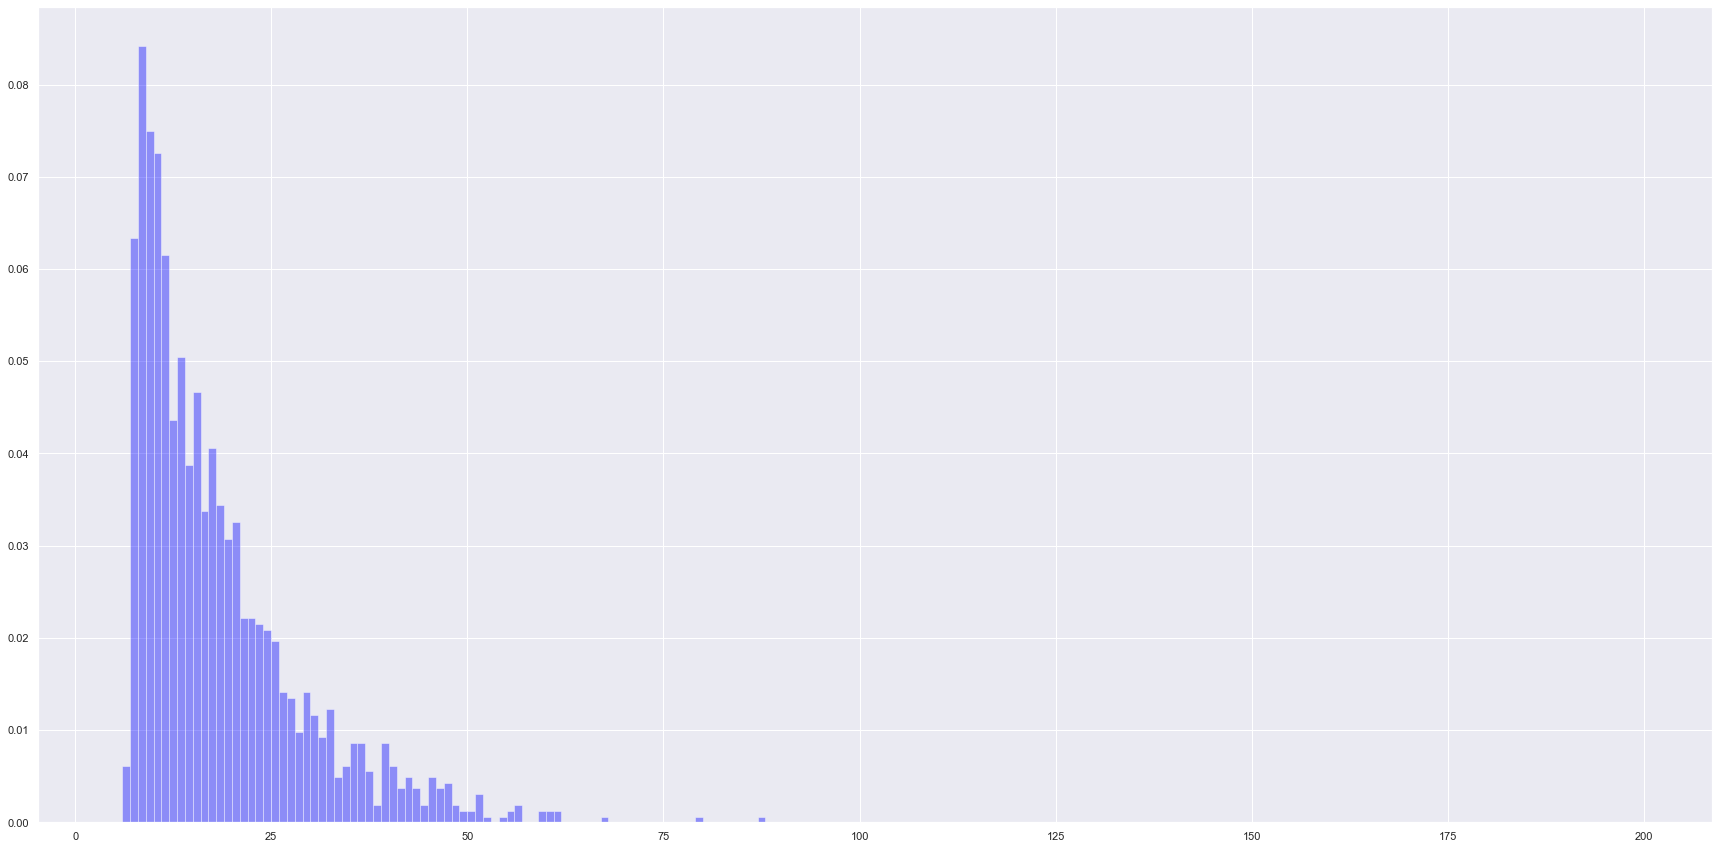

In [3]:
#plt.figure(figsize=(30,15))
sns.set(rc={"figure.figsize": (30, 15)})
#plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, hspace=0.12)
colors = ['blue'] #['firebrick', 'darkorange', 'olive','dodgerblue']
for x in colors:
    apic_secs = list(L5PC.all)
    for sec in apic_secs:
        for seg in sec:
            try: seg.Ih.vshift = seg.Ih.vshift + 30
#             try: seg.Ca_HVA.gCa_HVAbar = seg.Ca_HVA.gCa_HVAbar * 2.5
            except AttributeError: continue 
                
    listOfISIs = []
    plateauISIs = []
    for i in range (0,10):    
        START_TIME = 25     # time to start the stimulus
        END_TIME = 3000     # time to end the stimulus
        TIME_PER_AMP = 5    # change amplitude every TIME_PER_AMP ms
        MEAN_AMP = 0.2      # the mean amplitude
        LAMBDA = 0.5        # the poisson mean
        MEAN_AMP_2 = 0.15      # the mean amplitude
        LAMBDA_2 = 3        # the poisson mean
        times = np.arange(START_TIME, END_TIME, TIME_PER_AMP)
        totime = END_TIME-START_TIME

        random_amplitude = 1 / (np.random.poisson(LAMBDA, times.shape[0]) + 1) \
                           - 1 / (np.random.poisson(LAMBDA, times.shape[0]) + 1)
        random_amplitude_2 = 1 / (np.random.poisson(LAMBDA_2, times.shape[0]) + 1) \
                           - 1 / (np.random.poisson(LAMBDA_2, times.shape[0]) + 1)
        random_amplitude += MEAN_AMP
        random_amplitude_2 += MEAN_AMP_2
        clamps = []
        clamps_records = []
        clamps2 = []
        clamps_records2 = []
        for t in range(times.shape[0]):
            stim = h.IClamp(L5PC.soma[0](0.5))
            stim.delay = times[t]
            stim.amp = random_amplitude[t]
            stim.dur = TIME_PER_AMP
            clamps.append(stim)
            clamps_records.append(h.Vector().record(stim._ref_i))

            stim2 = h.IClamp(L5PC.apic[36](0.9))
            stim2.delay = times[t]
            stim2.amp = random_amplitude_2[t]
            stim2.dur = TIME_PER_AMP
            clamps2.append(stim2)
            clamps_records2.append(h.Vector().record(stim2._ref_i))

        neuron_times = h.Vector().record(h._ref_t)
        threshold = -20
        som_v = h.Vector().record(L5PC.soma[0](0.5)._ref_v)
        distal_v = h.Vector().record(L5PC.apic[36](0.9)._ref_v)
        count = 0
        h.finitialize(-80*mV)
        h.continuerun(END_TIME + 50)
        stimulus_as_one_array = np.sum([np.array(rec) for rec in clamps_records], axis=0)
        stimulus_as_one_array_2 = np.sum([np.array(rec) for rec in clamps_records2], axis=0)
        sumi = stimulus_as_one_array + stimulus_as_one_array_2


        origRecordingTime = np.array(neuron_times.to_python())
        origSomaVoltage   = np.array(som_v.to_python())
        origNexusVoltage  = np.array(distal_v.to_python())

        # high res - origNumSamplesPerMS per ms
        recordingTimeHighRes = np.arange(0, totime, 1.0 / 8)
        somaVoltageHighRes   = np.interp(recordingTimeHighRes, origRecordingTime, origSomaVoltage)
        nexusVoltageHighRes  = np.interp(recordingTimeHighRes, origRecordingTime, origNexusVoltage)


        risingBefore = np.hstack((0, somaVoltageHighRes[1:] - somaVoltageHighRes[:-1])) > 0
        fallingAfter = np.hstack((somaVoltageHighRes[1:] - somaVoltageHighRes[:-1], 0)) < 0
        localMaximum = np.logical_and(fallingAfter, risingBefore)
        largerThanThresh = somaVoltageHighRes > -25

        binarySpikeVector = np.logical_and(localMaximum,largerThanThresh)
        spikeInds = np.nonzero(binarySpikeVector)
        outputSpikeTimes = recordingTimeHighRes[spikeInds]

        risingNexus = np.hstack((0, nexusVoltageHighRes[1:] - somaVoltageHighRes[:-1])) > -10
        fallingNexus = np.hstack((nexusVoltageHighRes[1:] - somaVoltageHighRes[:-1], 0)) < -10
        nexusMaximum = np.logical_and(fallingNexus, risingNexus)
        largerThanThreshNex = nexusVoltageHighRes > -20

        binaryPlateauVector = np.logical_and(nexusMaximum,largerThanThreshNex)
        plateauInds = np.nonzero(binaryPlateauVector)
        outputPlateauTimes = recordingTimeHighRes[plateauInds]

        
        listOfISIs += list(np.diff(outputSpikeTimes))
        ISICV = np.std(listOfISIs) / np.mean(listOfISIs)
        plateauISIs += list(np.diff(outputPlateauTimes))
        print(i)
           
    print(ISICV) 
    for sec in apic_secs:
        for seg in sec:
            try: seg.Ih.vshift = seg.Ih.vshift - 30
#             try: seg.Ca_HVA.gCa_HVAbar = seg.Ca_HVA.gCa_HVAbar / 2.5
            except AttributeError: continue 
    plt.hist(listOfISIs, color = x, density = True, alpha=0.4, bins=range(5,200,1))
#     mult = 2.5
    df = pd.DataFrame({'A': listOfISIs, 'B': x})
    #plt.gca().set_xscale("log")
    #bins=range(5,60,1)
#     sns.kdeplot(listOfISIs, color = x, common_norm = False, cut = 0, fill = False, alpha = 0.7) 
file_name = 'df.xlsx'
df.to_excel(file_name)
plt.show()